# 5.0 Machine Learning
We will train several models on the data, using cross-validation to pick the best hyperparameters, and select the most promising model. The model will finally be evaulated on the test set.

In [34]:
import numpy as np
import os
import pandas as pd
pd.set_option('display.max_columns', 200)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.metrics import mean_squared_error, make_scorer
   
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [35]:
np.random.seed(101)

### Read in the data

In [36]:
DATA_FOLDER = os.path.join('data', 'final')

In [37]:
zoopla_df_train = pd.read_csv(os.path.join(DATA_FOLDER, 'zoopla_train.csv'), dtype=str)
zoopla_df_test = pd.read_csv(os.path.join(DATA_FOLDER, 'zoopla_test.csv'), dtype=str)

In [38]:
zoopla_df_train.columns

Index(['TOTAL_FLOOR_AREA_median', 'diff_published_date', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6',
       'cluster_7', 'num_bedrooms', 'num_bathrooms',
       'CURRENT_ENERGY_RATING_mode', 'POTENTIAL_ENERGY_RATING_mode',
       'CONSTRUCTION_AGE_BAND_mode', 'Index of Multiple Deprivation Decile',
       'Income Decile', 'Employment Decile', 'Education and Skills Decile',
       'Health and Disability Decile', 'Crime Decile',
       'Barriers to Housing and Services Decile', 'Living Environment Decile',
       'IDACI Decile', 'IDAOPI Decile', 'last_published_year',
       'last_published_month', 'first_published_year', 'first_published_month',
       'post_town_Nuneaton', 'parish_Hinckley and Bosworth, unparished area',
       'parish_Nuneaton and Bedworth, unparished area', 'parish_Other',
       'parish_Stoke Golding', 'postcode_CV10 7', 'postcode_CV10 8',
       'postcode_CV10 9', 'postcode_CV11 4', 'postcode_CV11 5',
       'postcode_CV11 6

In [39]:
X_train = zoopla_df_train.drop('LOG_price', axis=1).astype(float)
y_train = zoopla_df_train['LOG_price'].astype(float)

X_test = zoopla_df_test.drop('LOG_price', axis=1).astype(float)
y_test = zoopla_df_test['LOG_price'].astype(float)

In [40]:
y_train

0      12.899220
1      12.429216
2      12.577636
3      13.217674
4      12.367341
         ...    
601    12.542545
602    12.886641
603    11.407565
604    13.091904
605    11.775290
Name: LOG_price, Length: 606, dtype: float64

In [41]:
X_train.head()

,TOTAL_FLOOR_AREA_median,diff_published_date,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,num_bedrooms,num_bathrooms,CURRENT_ENERGY_RATING_mode,POTENTIAL_ENERGY_RATING_mode,CONSTRUCTION_AGE_BAND_mode,Index of Multiple Deprivation Decile,Income Decile,Employment Decile,Education and Skills Decile,Health and Disability Decile,Crime Decile,Barriers to Housing and Services Decile,Living Environment Decile,IDACI Decile,IDAOPI Decile,last_published_year,last_published_month,first_published_year,first_published_month,post_town_Nuneaton,"parish_Hinckley and Bosworth, unparished area","parish_Nuneaton and Bedworth, unparished area",parish_Other,parish_Stoke Golding,postcode_CV10 7,postcode_CV10 8,postcode_CV10 9,postcode_CV11 4,postcode_CV11 5,postcode_CV11 6,postcode_CV11 7,postcode_CV12 9,postcode_CV13 0,postcode_CV13 6,postcode_CV9 3,postcode_LE10 0,postcode_LE10 1,postcode_LE10 2,postcode_LE10 3,postcode_LE9 7,PROB_4BAND_Medium,PROB_4BAND_None,property_type_general_Detached house,property_type_general_End terrace house,property_type_general_Flat,property_type_general_Maisonette,property_type_general_Other/Unknown,property_type_general_Semi-detached house,property_type_general_Terraced house
0,0.755945,-0.699124,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.075124,0.825820,1.617842,1.700535,-0.534404,-1.164162,-1.237357,-1.544492,-1.481684,-0.244458,-0.112069,0.983099,1.030554,-0.777371,-0.589032,-1.544498,1.117375,-0.576376,0.502342,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.171376,-0.325847,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.010751,-0.480830,0.473837,-0.149598,0.088982,-0.028729,-0.093148,0.109151,-0.282351,-0.689328,0.706170,-0.248654,0.636538,-0.373352,1.017057,-1.544498,1.574432,-0.576376,0.745100,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.501176,0.047430,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.010751,-0.480830,0.473837,-0.149598,-0.534404,1.106703,1.051061,0.935973,1.316759,0.200412,0.706170,0.572515,-0.151495,1.646747,0.615535,0.647459,-0.710851,-0.576376,0.745100,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2.699468,0.047430,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.075124,0.825820,1.617842,1.700535,-1.157791,-0.407207,-0.474551,0.109151,-0.682129,-1.134197,-0.521189,1.393684,-0.939527,-0.373352,-0.589032,-1.544498,1.802960,-0.576376,0.502342,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.632287,0.793983,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.010751,-1.787481,-0.670168,-0.149598,0.088982,-0.785684,-0.855954,-0.717670,-0.682129,-0.689328,-1.339428,0.983099,-0.545511,-0.373352,-0.589032,0.647459,-0.482323,-0.576376,0.502342,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [42]:
for colname in X_train.columns:
    display(X_train[colname].value_counts(dropna=False))

-0.200393    100
 0.138953     13
-0.385490     13
-0.231242     12
-0.447189     12
            ... 
-0.432983      1
 0.345337      1
-0.458763      1
 2.282999      1
 0.773529      1
Name: TOTAL_FLOOR_AREA_median, Length: 207, dtype: int64

-0.699124    259
-0.325847     96
 0.047430     79
 0.420706     56
 0.793983     39
 1.167259     28
 1.913813     18
 1.540536     13
 2.660366      6
 3.033643      3
 3.406919      2
 3.780196      2
 5.273303      1
 4.526749      1
 9.379346      1
 6.019856      1
 2.287089      1
Name: diff_published_date, dtype: int64

0.0    526
1.0     80
Name: cluster_1, dtype: int64

0.0    536
1.0     70
Name: cluster_2, dtype: int64

0.0    480
1.0    126
Name: cluster_3, dtype: int64

0.0    500
1.0    106
Name: cluster_4, dtype: int64

0.0    554
1.0     52
Name: cluster_5, dtype: int64

0.0    603
1.0      3
Name: cluster_6, dtype: int64

0.0    533
1.0     73
Name: cluster_7, dtype: int64

-0.010751    277
 1.075124    147
-1.096626    140
 2.160999     18
-2.182501     15
-3.268376      6
 4.332749      2
 3.246874      1
Name: num_bedrooms, dtype: int64

-0.480830    335
 0.825820    174
-1.787481     50
 2.132471     42
 3.439122      5
Name: num_bathrooms, dtype: int64

 0.473837    348
-0.670168    110
-1.814173     98
 1.617842     45
 2.761848      5
Name: CURRENT_ENERGY_RATING_mode, dtype: int64

-0.149598    431
 1.700535    109
-1.999732     64
 3.550669      2
Name: POTENTIAL_ENERGY_RATING_mode, dtype: int64

-0.846097    228
 0.088982     61
-0.222711     54
-0.534404     47
 0.712368     41
 1.335754     32
 2.270833     32
 1.647447     29
 0.400675     24
 1.024061     24
-1.157791     22
 1.959140     12
Name: CONSTRUCTION_AGE_BAND_mode, dtype: int64

 0.728226    158
-0.028729     68
-0.785684     65
-1.164162     58
-0.407207     56
 1.106703     53
 1.485181     53
-1.921117     36
-1.542639     32
 0.349748     27
Name: Index of Multiple Deprivation Decile, dtype: int64

 1.051061    135
 0.288255    102
-0.474551     80
-0.855954     66
 1.432465     53
-1.237357     47
-1.618760     39
-0.093148     38
 0.669658     24
-2.000164     22
Name: Income Decile, dtype: int64

 0.109151    144
 0.935973     97
 1.349384     88
-0.717670     67
-1.131081     62
-1.544492     41
 0.522562     36
-0.304259     35
-1.957903     31
 1.762795      5
Name: Employment Decile, dtype: int64

-0.682129    119
 0.117426     94
-0.282351     85
 1.316759     82
-1.481684     62
-1.081906     54
 1.716537     48
 0.916982     31
 0.517204     25
 2.116314      6
Name: Education and Skills Decile, dtype: int64

 0.645281    116
-0.244458     87
-0.689328     83
 0.200412     78
-1.134197     65
 1.535020     56
 1.090151     44
-1.579067     44
-2.023936     17
 1.979890     16
Name: Health and Disability Decile, dtype: int64

-0.521189    132
 0.297051     87
 0.706170     86
-0.930308     62
 1.115290     48
-1.748548     45
 1.524410     45
-0.112069     38
-1.339428     37
 1.933529     26
Name: Crime Decile, dtype: int64

 0.572515    120
-1.069823     96
 0.983099     91
 0.161930     87
-1.480408     69
 1.393684     67
-0.659239     38
-0.248654     25
-2.301577     12
-1.890992      1
Name: Barriers to Housing and Services Decile, dtype: int64

-0.151495    122
 1.030554     95
-0.939527     86
 1.424570     84
 0.636538     53
-0.545511     51
-1.727559     48
 0.242521     33
-1.333543     29
-2.121575      5
Name: Living Environment Decile, dtype: int64

-0.373352    115
 1.242727     96
 0.838708     90
-0.777371     64
 0.030668     64
 0.434688     55
-1.989431     36
-1.585411     35
-1.181391     30
 1.646747     21
Name: IDACI Decile, dtype: int64

 1.017057    120
-0.589032     95
 0.615535     92
-0.187509     77
-0.990554     54
 1.418579     51
 0.214013     42
-1.793598     33
-2.195120     23
-1.392076     19
Name: IDAOPI Decile, dtype: int64

 0.647459    427
-1.544498    179
Name: last_published_year, dtype: int64

-0.710851    290
-0.482323    137
 1.574432     77
 1.802960     47
 1.345904     36
 1.117375     11
 0.888847      6
 0.431790      1
-0.253795      1
Name: last_published_month, dtype: int64

-0.576376    420
 1.490392    178
-2.643143      7
-4.709910      1
Name: first_published_year, dtype: int64

-1.439726    154
 0.745100     97
 0.987859     87
 0.502342     77
 1.230618     50
 0.259583     45
 0.016825     33
-1.196968     28
-0.225934     21
-0.954209      6
-0.711451      5
-0.468692      3
Name: first_published_month, dtype: int64

1.0    408
0.0    198
Name: post_town_Nuneaton, dtype: int64

0.0    417
1.0    189
Name: parish_Hinckley and Bosworth, unparished area, dtype: int64

1.0    394
0.0    212
Name: parish_Nuneaton and Bedworth, unparished area, dtype: int64

0.0    598
1.0      8
Name: parish_Other, dtype: int64

0.0    600
1.0      6
Name: parish_Stoke Golding, dtype: int64

0.0    564
1.0     42
Name: postcode_CV10 7, dtype: int64

0.0    561
1.0     45
Name: postcode_CV10 8, dtype: int64

0.0    534
1.0     72
Name: postcode_CV10 9, dtype: int64

0.0    561
1.0     45
Name: postcode_CV11 4, dtype: int64

0.0    582
1.0     24
Name: postcode_CV11 5, dtype: int64

0.0    514
1.0     92
Name: postcode_CV11 6, dtype: int64

0.0    592
1.0     14
Name: postcode_CV11 7, dtype: int64

0.0    605
1.0      1
Name: postcode_CV12 9, dtype: int64

0.0    603
1.0      3
Name: postcode_CV13 0, dtype: int64

0.0    597
1.0      9
Name: postcode_CV13 6, dtype: int64

0.0    605
1.0      1
Name: postcode_CV9 3, dtype: int64

0.0    485
1.0    121
Name: postcode_LE10 0, dtype: int64

0.0    542
1.0     64
Name: postcode_LE10 1, dtype: int64

0.0    599
1.0      7
Name: postcode_LE10 2, dtype: int64

0.0    600
1.0      6
Name: postcode_LE10 3, dtype: int64

0.0    605
1.0      1
Name: postcode_LE9 7, dtype: int64

0.0    601
1.0      5
Name: PROB_4BAND_Medium, dtype: int64

1.0    597
0.0      9
Name: PROB_4BAND_None, dtype: int64

0.0    406
1.0    200
Name: property_type_general_Detached house, dtype: int64

0.0    577
1.0     29
Name: property_type_general_End terrace house, dtype: int64

0.0    555
1.0     51
Name: property_type_general_Flat, dtype: int64

0.0    602
1.0      4
Name: property_type_general_Maisonette, dtype: int64

0.0    586
1.0     20
Name: property_type_general_Other/Unknown, dtype: int64

0.0    418
1.0    188
Name: property_type_general_Semi-detached house, dtype: int64

0.0    526
1.0     80
Name: property_type_general_Terraced house, dtype: int64

### Try fitting a simple linear regression model
We will use cross-validation to try different regularisation pararameters

RSME = 0.2192546021978383


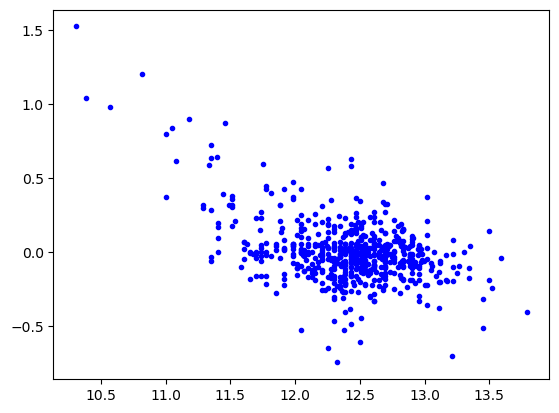

In [44]:
simple_lin_model = LinearRegression()
simple_lin_model.fit(X_train, y_train)
y_preds = simple_lin_model.predict(X_train)

print('RSME =', mean_squared_error(y_train, y_preds, squared=False))

plt.plot(y_train, y_preds-y_train, 'b.')

In [46]:
def RMSE(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print('RMSE: %2.3f', rmse)
    return rmse

#define your own mse and set greater_is_better=False
rmse = make_scorer(RMSE, greater_is_better=False)

In [47]:
# Smaller C = more regularisation
lin_model_param_grid = {'alpha': [0, 0.001, 0.01, 0.1, 1, 2, 3, 5, 10], 'max_iter': [200]}

# scan all values of C and pick the one that optimises recall
grid_search_lin_model = GridSearchCV(Ridge(random_state=101), lin_model_param_grid, cv=5, verbose=3, scoring=rmse)
grid_search_lin_model.fit(X_train, y_train)

print("Best value for C =", grid_search_lin_model.best_params_)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
RMSE: %2.3f 1441260827615.1843
[CV 1/5] END alpha=0, max_iter=200;, score=-1441260827615.184 total time=   0.0s
RMSE: %2.3f 1318608102081.2808
[CV 2/5] END alpha=0, max_iter=200;, score=-1318608102081.281 total time=   0.0s
RMSE: %2.3f 4948907622762.905
[CV 3/5] END alpha=0, max_iter=200;, score=-4948907622762.905 total time=   0.0s
RMSE: %2.3f 0.21857636029739494
[CV 4/5] END ............alpha=0, max_iter=200;, score=-0.219 total time=   0.0s
RMSE: %2.3f 0.25639009741305235
[CV 5/5] END ............alpha=0, max_iter=200;, score=-0.256 total time=   0.0s
RMSE: %2.3f 0.27359580477948714
[CV 1/5] END ........alpha=0.001, max_iter=200;, score=-0.274 total time=   0.0s
RMSE: %2.3f 0.2786667876237368
[CV 2/5] END ........alpha=0.001, max_iter=200;, score=-0.279 total time=   0.0s
RMSE: %2.3f 0.26498530347226845
[CV 3/5] END ........alpha=0.001, max_iter=200;, score=-0.265 total time=   0.0s
RMSE: %2.3f 0.21816380907625355
[CV 4/5] 

RSME = 0.22285465566072793


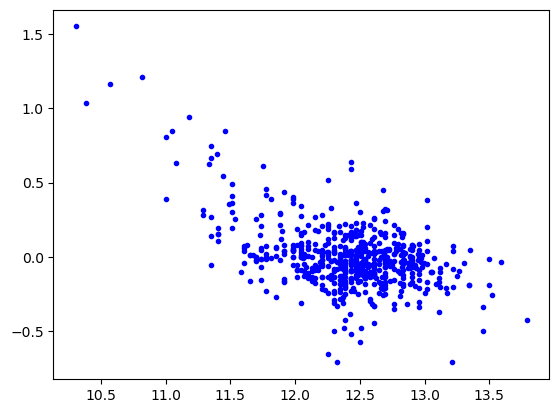

In [48]:
y_preds = grid_search_lin_model.best_estimator_.predict(X_train)

print('RSME =', mean_squared_error(y_train, y_preds, squared=False))

plt.plot(y_train, y_preds-y_train, 'b.')

### Now try KNN Regressor

In [51]:
# Smaller C = more regularisation
knn_model_param_grid = {'n_neighbors': [1, 2, 4, 8, 10, 20, 40]}

# scan all values of C and pick the one that optimises recall
grid_search_knn_model = GridSearchCV(KNeighborsRegressor(), knn_model_param_grid, cv=5, verbose=3, scoring=rmse)
grid_search_knn_model.fit(X_train, y_train)

print("Best value for k =", grid_search_knn_model.best_params_)


Fitting 5 folds for each of 7 candidates, totalling 35 fits
RMSE: %2.3f 0.38586137966446216
[CV 1/5] END ....................n_neighbors=1;, score=-0.386 total time=   0.1s
RMSE: %2.3f 0.42485555864368546
[CV 2/5] END ....................n_neighbors=1;, score=-0.425 total time=   0.0s
RMSE: %2.3f 0.4198085814173376
[CV 3/5] END ....................n_neighbors=1;, score=-0.420 total time=   0.0s
RMSE: %2.3f 0.4122312785614724
[CV 4/5] END ....................n_neighbors=1;, score=-0.412 total time=   0.0s
RMSE: %2.3f 0.376944099461183
[CV 5/5] END ....................n_neighbors=1;, score=-0.377 total time=   0.0s
RMSE: %2.3f 0.3305510087762619
[CV 1/5] END ....................n_neighbors=2;, score=-0.331 total time=   0.0s
RMSE: %2.3f 0.40313799315398985
[CV 2/5] END ....................n_neighbors=2;, score=-0.403 total time=   0.0s
RMSE: %2.3f 0.37054498835624144
[CV 3/5] END ....................n_neighbors=2;, score=-0.371 total time=   0.0s
RMSE: %2.3f 0.3442790543676485
[CV 4/5] E

RSME = 0.24626547549179112


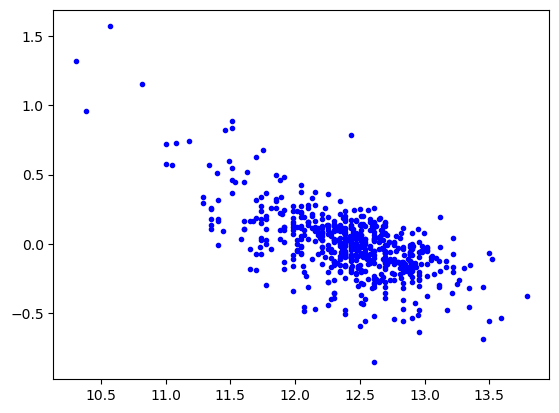

In [53]:
y_preds = grid_search_knn_model.best_estimator_.predict(X_train)

print('RSME =', mean_squared_error(y_train, y_preds, squared=False))

plt.plot(y_train, y_preds-y_train, 'b.')

### Now try SVC classifier

In [13]:
svc_model_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('svc_model', SVC())
])

svc_param_search = {'svc_model__C': [0.1, 1, 10], 'svc_model__gamma': [0.1, 1, 10], 'svc_model__kernel': ['rbf']}

# scan all values of the parameters and pick the ones that optimise recall
random_search_svc_model = RandomizedSearchCV(svc_model_pipeline, svc_param_search, n_iter=6, cv=3, verbose=3, scoring='recall')
random_search_svc_model.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END svc_model__C=10, svc_model__gamma=1, svc_model__kernel=rbf;, score=0.664 total time= 2.1min
[CV 2/3] END svc_model__C=10, svc_model__gamma=1, svc_model__kernel=rbf;, score=0.654 total time= 1.6min
[CV 3/3] END svc_model__C=10, svc_model__gamma=1, svc_model__kernel=rbf;, score=0.657 total time= 1.3min
[CV 1/3] END svc_model__C=0.1, svc_model__gamma=10, svc_model__kernel=rbf;, score=0.736 total time= 1.1min
[CV 2/3] END svc_model__C=0.1, svc_model__gamma=10, svc_model__kernel=rbf;, score=0.729 total time= 1.1min
[CV 3/3] END svc_model__C=0.1, svc_model__gamma=10, svc_model__kernel=rbf;, score=0.744 total time= 1.1min
[CV 1/3] END svc_model__C=0.1, svc_model__gamma=0.1, svc_model__kernel=rbf;, score=0.677 total time= 1.0min
[CV 2/3] END svc_model__C=0.1, svc_model__gamma=0.1, svc_model__kernel=rbf;, score=0.674 total time= 1.2min
[CV 3/3] END svc_model__C=0.1, svc_model__gamma=0.1, svc_model__kernel=rbf;, score=0.672

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('full_pipeline',
                                              ColumnTransformer(transformers=[('numeric',
                                                                               Pipeline(steps=[('num_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('num_std_scaler',
                                                                                                StandardScaler())]),
                                                                               ['LOG_LIFETIME_VALUE_PER_YEAR',
                                                                                'LOG_LIFETIME_VALUE',
                                                                                'LOG_LIFETIME_TRANSACTION_COUNT']),
                                                                              ('discrete',
                                                                               Pipeline(steps=[('dis_imputer',
                                                                                                SimpleI...
                                                                                'RETAILER_MARKETING_OPT_IN']),
                                                                              ('categoric',
                                                                               Pipeline(steps=[('cat_imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('cat_oh_encoder',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['CUSTOMER_SEGMENT'])])),
                                             ('svc_model', SVC())]),
                   n_iter=6,
                   param_distributions={'svc_model__C': [0.1, 1, 10],
                                        'svc_model__gamma': [0.1, 1, 10],
                                        'svc_model__kernel': ['rbf']},
                   scoring='recall', verbose=3)

### Now try Decision Tree classifier

In [14]:
tree_model_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('tree_model', DecisionTreeClassifier())
])

tree_param_search = {'tree_model__max_depth': [1, 2, 3, 5, 7, 9], 'tree_model__min_samples_split': [2, 4, 6, 10, 16]}

# scan all values of the parameters and pick the ones that optimise recall
random_search_tree_model = RandomizedSearchCV(tree_model_pipeline, tree_param_search, n_iter=10,  cv=5, verbose=3, scoring='recall')
random_search_tree_model.fit(X_train, y_train)

print("Best params =", random_search_tree_model.best_params_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END tree_model__max_depth=2, tree_model__min_samples_split=2;, score=0.468 total time=   0.1s
[CV 2/5] END tree_model__max_depth=2, tree_model__min_samples_split=2;, score=0.540 total time=   0.1s
[CV 3/5] END tree_model__max_depth=2, tree_model__min_samples_split=2;, score=0.532 total time=   0.1s
[CV 4/5] END tree_model__max_depth=2, tree_model__min_samples_split=2;, score=0.701 total time=   0.1s
[CV 5/5] END tree_model__max_depth=2, tree_model__min_samples_split=2;, score=0.593 total time=   0.1s
[CV 1/5] END tree_model__max_depth=7, tree_model__min_samples_split=6;, score=0.645 total time=   0.1s
[CV 2/5] END tree_model__max_depth=7, tree_model__min_samples_split=6;, score=0.623 total time=   0.1s
[CV 3/5] END tree_model__max_depth=7, tree_model__min_samples_split=6;, score=0.727 total time=   0.1s
[CV 4/5] END tree_model__max_depth=7, tree_model__min_samples_split=6;, score=0.677 total time=   0.1s
[CV 5/5] END

Let's look at the best tree. We will fit a decision tree with the best parameters (from the above cross-validation) on the training data and draw the tree

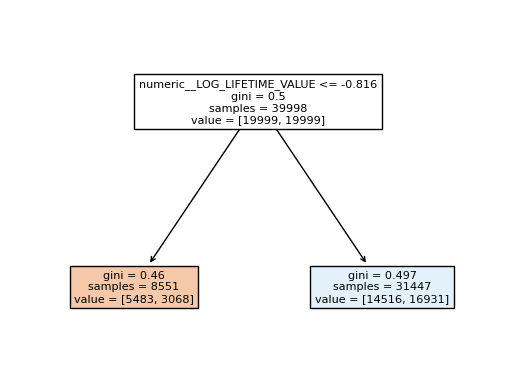

In [15]:
tree_model_best_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('tree_model_best', DecisionTreeClassifier(max_depth=1, min_samples_split=2))
])

tree_model_best_pipeline.fit(X_train, y_train)
tree_model_best_pipeline.predict(X_train)

from sklearn.tree import plot_tree
plot_t = plot_tree(tree_model_best_pipeline[1], feature_names=tree_model_best_pipeline[:-1].get_feature_names_out(), filled=True)

### Trees look promising. Let's try a Random Forest

In [16]:
forest_model_pipeline = Pipeline([
    ('full_pipeline', full_pipeline),
    ('forest_model', RandomForestClassifier())
])

forest_param_search = {'forest_model__n_estimators': [50, 100, 300, 500], 
                     'forest_model__max_depth': [1, 2, 3, 5, 7, 9], 
                     'forest_model__min_samples_split': [2, 4, 8, 16]}

# scan all values of the parameters and pick the ones that optimise recall
random_search_forest_model = RandomizedSearchCV(forest_model_pipeline, forest_param_search, cv=5, verbose=3, scoring='recall')
random_search_forest_model.fit(X_train, y_train)

print("Best params =", random_search_forest_model.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END forest_model__max_depth=5, forest_model__min_samples_split=2, forest_model__n_estimators=50;, score=0.682 total time=   1.0s
[CV 2/5] END forest_model__max_depth=5, forest_model__min_samples_split=2, forest_model__n_estimators=50;, score=0.702 total time=   1.0s
[CV 3/5] END forest_model__max_depth=5, forest_model__min_samples_split=2, forest_model__n_estimators=50;, score=0.694 total time=   1.0s
[CV 4/5] END forest_model__max_depth=5, forest_model__min_samples_split=2, forest_model__n_estimators=50;, score=0.697 total time=   0.9s
[CV 5/5] END forest_model__max_depth=5, forest_model__min_samples_split=2, forest_model__n_estimators=50;, score=0.723 total time=   0.9s
[CV 1/5] END forest_model__max_depth=9, forest_model__min_samples_split=8, forest_model__n_estimators=300;, score=0.687 total time=   8.0s
[CV 2/5] END forest_model__max_depth=9, forest_model__min_samples_split=8, forest_model__n_estimators=300;, sc

Plot feature importances

In [17]:
random_search_forest_model.best_estimator_._final_estimator.feature_importances_

array([1.84165078e-01, 4.96975370e-01, 5.23680004e-02, 2.56395169e-02,
       1.92782134e-02, 2.20299069e-01, 8.87149363e-04, 2.83721024e-04,
       1.03881600e-04])

In [18]:
importances = pd.Series(data=random_search_forest_model.best_estimator_._final_estimator.feature_importances_,
                            index=random_search_forest_model.best_estimator_[:-1].get_feature_names_out())

In [19]:
importances = importances.sort_values(ascending=True)

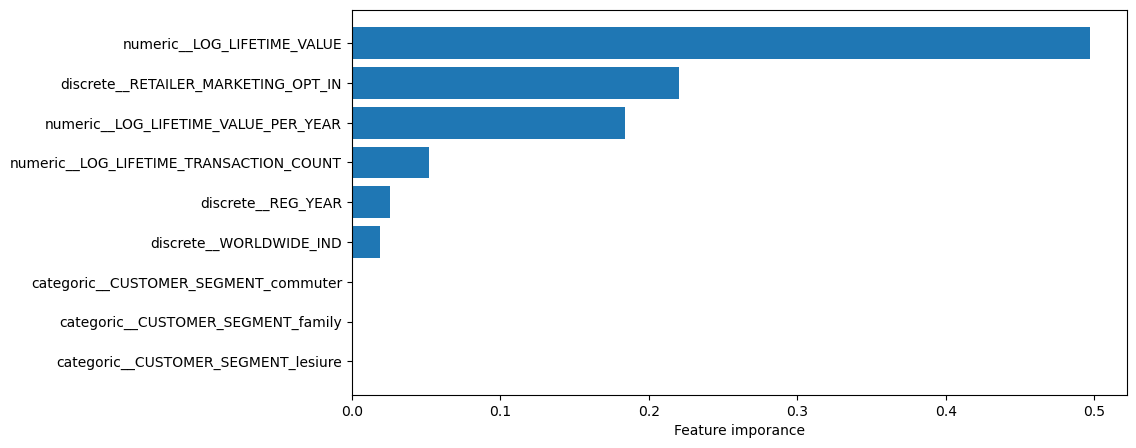

In [20]:
plt.figure(figsize=(10, 5))
plt.barh(range(len(importances)), importances.values)
plt.yticks(range(len(importances)), importances.index);
plt.xlabel('Feature imporance')
plt.show()

### Precision-recall plots on training data
Using the best model from the taining above, we will choose a probability threshold that maximises precision

In [31]:
best_model = random_search_forest_model

In [32]:
y_train_preds = best_model.best_estimator_.predict(X_train)
y_train_probas = best_model.best_estimator_.predict_proba(X_train)

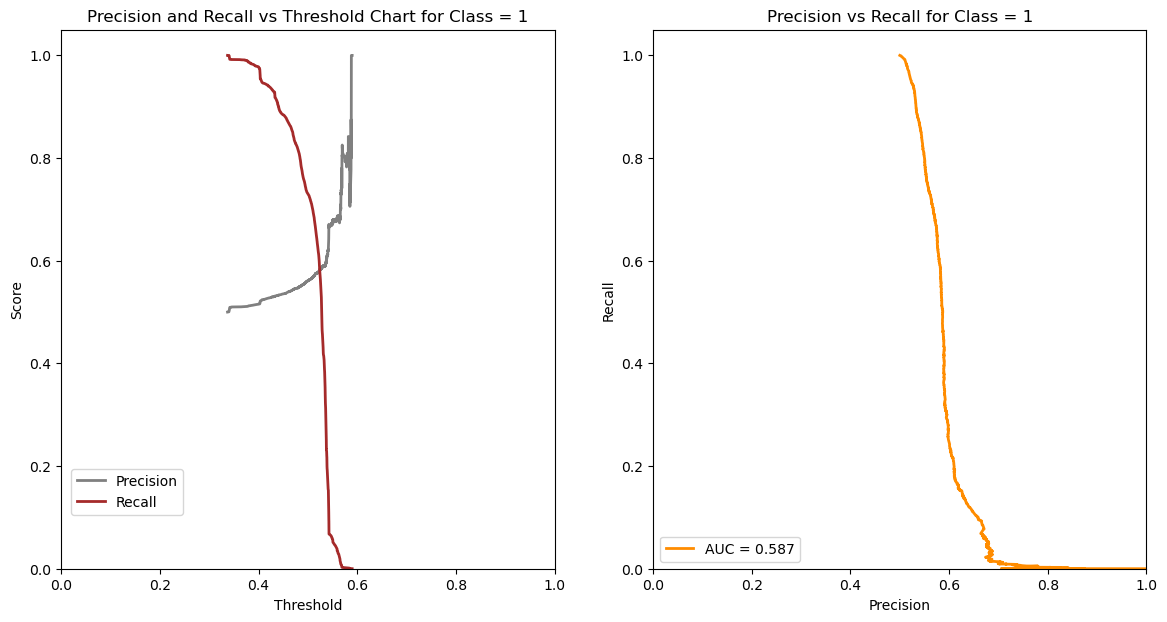

In [38]:
get_precision_recall_curves(y_train, y_train_probas)

A probability of about 0.5 seems like a good trade-off

### Try out best params on test set and evaulate it

In [62]:
proba_threshold = 0.5

In [63]:
y_test_probas = best_model.best_estimator_.predict_proba(X_test)
y_test_preds = (best_model.best_estimator_.predict_proba(X_test)[:,1] >= proba_threshold).astype(bool)

In [64]:
print(classification_report(y_test, y_test_preds))

              precision    recall  f1-score   support

         0.0       0.60      0.43      0.50      5000
         1.0       0.56      0.72      0.63      5000

    accuracy                           0.57     10000
   macro avg       0.58      0.57      0.56     10000
weighted avg       0.58      0.57      0.56     10000



<Axes: >

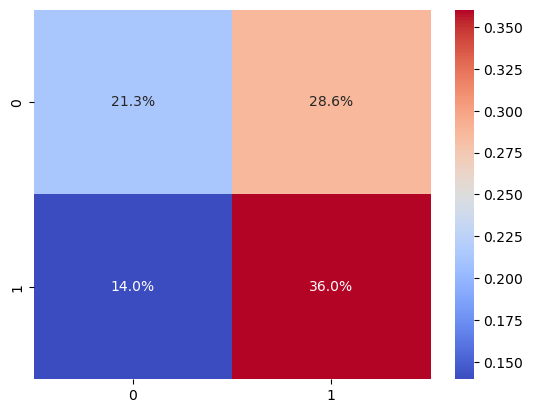

In [65]:
sns.heatmap(confusion_matrix(y_test, y_test_preds)/len(y_test), annot=True, cmap='coolwarm', fmt=".1%")

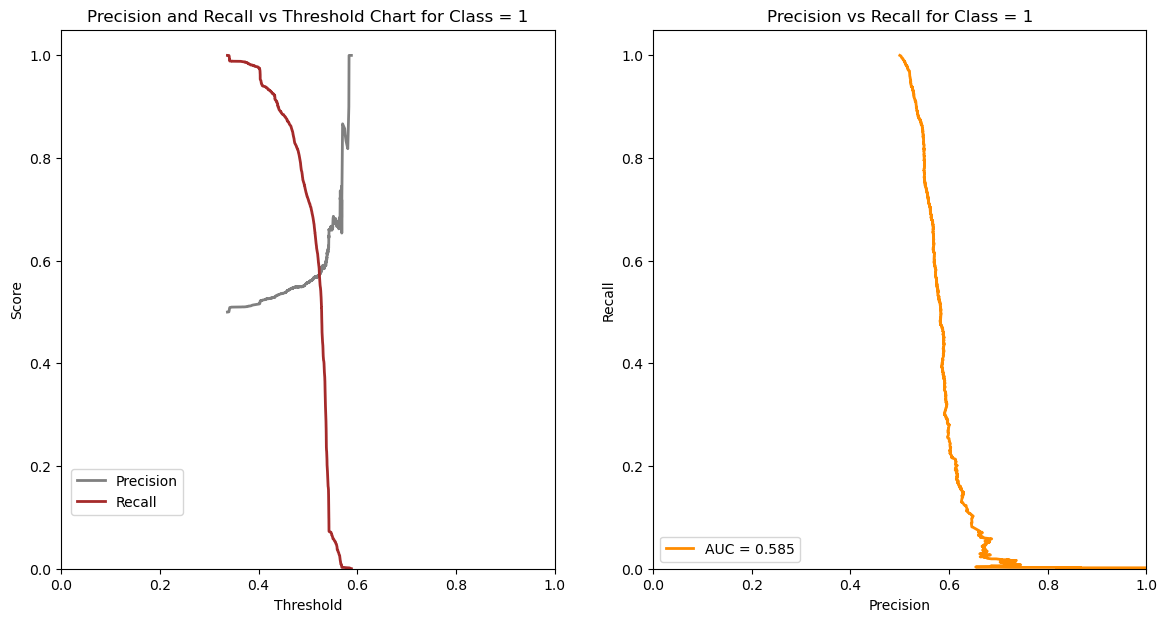

In [66]:
get_precision_recall_curves(y_test, y_test_probas)

With this probability threshold, we reach a reasonable recall of 72% although do get many false positives